# Running TCAV


This notebook walks you through things you need to run TCAV. In high level, you need:

1. **example images in each folder**
 * images for each concept
 * images for the class/labels of interest
 * random images that will be negative examples when learning CAVs (images that probably don't belong to any concepts)
2. **model wrapper**: an instance of  ModelWrapper abstract class (in model.py). This tells TCAV class (tcav.py) how to communicate with your model (e.g., getting internal tensors)
3. **act_generator**: an instance of ActivationGeneratorInterface that tells TCAV class how to load example data and how to get activations from the model



## Requirements

    Install sklearn and PIL before running below!

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cav as cav
import model as model
import tcav as tcav
import utils as utils
import utils_plot as utils_plot # utils_plot requires matplotlib
import os
import logging
import torch
import activation_generator as act_gen

## Step 1. Store concept and target class images to local folders

and tell TCAV where they are.

**source_dir**: where images of concepts, target class and random images (negative samples when learning CAVs) live. Each should be a sub-folder within this directory.

Note that random image directories can be in any name. In this example, we are using `random500_0`, `random500_1`,.. for an arbitrary reason. 


You need roughly 50-200 images per concept and target class (10-20 pictures also tend to work, but 200 is pretty safe).


**cav_dir**: directory to store CAVs (`None` if you don't want to store)

**target, concept**: names of the target class (that you want to investigate) and concepts (strings) - these are folder names in source_dir

**bottlenecks**: list of bottleneck names (intermediate layers in your model) that you want to use for TCAV. These names are defined in the model wrapper below.



In [21]:
working_dir = './tcav_class_test'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
grads_dir = working_dir + '/grads/'
results_dir = working_dir + '/results/'
logs_dir = working_dir + '/logs/'
source_dir = "F:/source"
bottlenecks = ['Mixed_5d']
      
utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)
utils.make_dir_if_not_exists(grads_dir)
utils.make_dir_if_not_exists(results_dir)
utils.make_dir_if_not_exists(logs_dir)

# this is a regularizer penalty parameter for linear classifier to get CAVs. 
alphas = [0.1]   

target = 'zebra'  
concepts = ["dotted","striped","zigzagged"]
random_counterpart = 'random500_0'

LABEL_PATH = './imagenet_comp_graph_label_strings.txt'

get_timestamp = lambda : datetime.datetime.now().strftime("%Y%m%d%H%M%S")

In [4]:
mymodel = model.InceptionV3Wrapper(LABEL_PATH)

## Step 3. Implement a class that returns activations (maybe with caching!)

Lastly, you will implement a class of the ActivationGenerationInterface which TCAV uses to load example data for a given concept or target, call into your model wrapper and return activations. I pulled out this logic outside of mymodel because this step often takes the longest. By making it modular, you can cache your activations and/or parallelize your computations, as I have done in `ActivationGeneratorBase.process_and_load_activations` in `activation_generator.py`.


The `process_and_load_activations` method of the activation generator must return a dictionary of activations that has concept or target name as  a first key, and the bottleneck name as a second key. So something like:

```python
{concept1: {bottleneck1: [[0.2, 0.1, ....]]},
concept2: {bottleneck1: [[0.1, 0.02, ....]]},
target1: {bottleneck1: [[0.02, 0.99, ....]]}
```


In [5]:
act_generator = act_gen.ImageActivationGenerator(mymodel, source_dir, activation_dir, max_examples=200)

## You are ready to run TCAV!

Let's do it.

**num_random_exp**: number of experiments to confirm meaningful concept direction. TCAV will search for this many folders named `random500_0`, `random500_1`, etc. You can alternatively set the `random_concepts` keyword to be a list of folders of random concepts. Run at least 10-20 for meaningful tests. 

**random_counterpart**: as well as the above, you can optionally supply a single folder with random images as the "positive set" for statistical testing. Reduces computation time at the cost of less reliable random TCAV scores. 


In [9]:
import sys
logging.basicConfig(
    format='%(asctime)s %(filename)s[line:%(lineno)d] %(levelname)s %(message)s',
    datefmt='%a %d %b %Y %H:%M:%S',
    filename=os.path.join(logs_dir, get_timestamp() + '.log'),
    level=logging.INFO)
# logging.getLogger().handlers[0].stream = sys.stdout 

num_random_exp=100 # folders (random500_0, random500_1)

mytcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   cav_hparams=None,
                   random_counterpart='random500_0',
                   cav_dir=cav_dir,
                   grads_dir=grads_dir,
                   num_random_exp=num_random_exp)

results = mytcav.run()
import datetime
import pickle
with open(os.path.join(results_dir, get_timestamp() + '.pkl'), 'wb') as f:
    pickle.dump(results, f)

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_1_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_2_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_3_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_4_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_5_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_6_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_7_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_8_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_9_targ

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_72_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_73_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_74_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_75_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_76_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_77_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_78_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random500_79_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_dotted_random50

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_43_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_44_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_45_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_46_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_47_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_48_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_49_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped_random500_50_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_striped

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_13_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_14_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_15_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_16_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_17_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_18_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_19_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_20_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO 

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_82_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_83_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_84_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_85_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_86_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_87_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_88_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_zigzagged_random500_89_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO 

Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_51_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_52_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_53_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_54_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_55_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_56_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_57_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py[line:348] INFO Mixed_5d_random500_0_random500_58_target_zebra_model_type_logistic_C_0.1
Thu 25 Mar 2021 15:28:00 tcav.py

Thu 25 Mar 2021 15:28:02 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:02 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_3_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:02 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:02 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_3-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:02 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:03 tcav.py[line:250] INFO Get TCAV score 0.36
Thu 25 Mar 2021 15:28:03 tcav.py[line:198] INFO Running param 3 of 400
Thu 25 Mar 2021 15:28:03 tcav.py[line:222] INFO running zebra ['dotted', 'random500_4']
Thu 25 Mar 2021 15:28:03 activation_gene

Thu 25 Mar 2021 15:28:08 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:08 tcav.py[line:250] INFO Get TCAV score 0.38
Thu 25 Mar 2021 15:28:08 tcav.py[line:198] INFO Running param 11 of 400
Thu 25 Mar 2021 15:28:08 tcav.py[line:222] INFO running zebra ['dotted', 'random500_12']
Thu 25 Mar 2021 15:28:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:09 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_12_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:09 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:09 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_12-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:09 model.py[li

Thu 25 Mar 2021 15:28:14 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_20_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:14 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:14 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_20-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:14 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:14 tcav.py[line:250] INFO Get TCAV score 0.34
Thu 25 Mar 2021 15:28:14 tcav.py[line:198] INFO Running param 20 of 400
Thu 25 Mar 2021 15:28:14 tcav.py[line:222] INFO running zebra ['dotted', 'random500_21']
Thu 25 Mar 2021 15:28:14 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:14 activation_

Thu 25 Mar 2021 15:28:19 tcav.py[line:250] INFO Get TCAV score 0.36
Thu 25 Mar 2021 15:28:19 tcav.py[line:198] INFO Running param 28 of 400
Thu 25 Mar 2021 15:28:19 tcav.py[line:222] INFO running zebra ['dotted', 'random500_29']
Thu 25 Mar 2021 15:28:19 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:19 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_29_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:19 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:19 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_29-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:19 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:19 tcav.py[lin

Thu 25 Mar 2021 15:28:24 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:24 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_37-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:24 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:24 tcav.py[line:250] INFO Get TCAV score 0.36
Thu 25 Mar 2021 15:28:24 tcav.py[line:198] INFO Running param 37 of 400
Thu 25 Mar 2021 15:28:24 tcav.py[line:222] INFO running zebra ['dotted', 'random500_38']
Thu 25 Mar 2021 15:28:25 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:25 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_38_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:25 activation_

Thu 25 Mar 2021 15:28:30 tcav.py[line:198] INFO Running param 45 of 400
Thu 25 Mar 2021 15:28:30 tcav.py[line:222] INFO running zebra ['dotted', 'random500_46']
Thu 25 Mar 2021 15:28:30 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:30 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_46_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:30 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:30 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_46-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:30 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:30 tcav.py[line:250] INFO Get TCAV score 0.26
Thu 25 Mar 2021 15:28:30 tcav.py[lin

Thu 25 Mar 2021 15:28:35 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_54-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:36 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:36 tcav.py[line:250] INFO Get TCAV score 0.42
Thu 25 Mar 2021 15:28:36 tcav.py[line:198] INFO Running param 54 of 400
Thu 25 Mar 2021 15:28:36 tcav.py[line:222] INFO running zebra ['dotted', 'random500_55']
Thu 25 Mar 2021 15:28:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_55_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:36 cav.py[line

Thu 25 Mar 2021 15:28:41 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:41 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_63_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:41 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:41 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_63-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:41 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:41 tcav.py[line:250] INFO Get TCAV score 0.38
Thu 25 Mar 2021 15:28:41 tcav.py[line:198] INFO Running param 63 of 400
Thu 25 Mar 2021 15:28:41 tcav.py[line:222] INFO running zebra ['dotted', 'random500_64']
Thu 25 Mar 2021 15:28:41 activation_

Thu 25 Mar 2021 15:28:46 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:46 tcav.py[line:250] INFO Get TCAV score 0.32
Thu 25 Mar 2021 15:28:46 tcav.py[line:198] INFO Running param 71 of 400
Thu 25 Mar 2021 15:28:46 tcav.py[line:222] INFO running zebra ['dotted', 'random500_72']
Thu 25 Mar 2021 15:28:47 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:47 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_72_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:47 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:47 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_72-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:47 model.py[li

Thu 25 Mar 2021 15:28:52 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_80_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:52 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:52 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_80-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:52 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:52 tcav.py[line:250] INFO Get TCAV score 0.36
Thu 25 Mar 2021 15:28:52 tcav.py[line:198] INFO Running param 80 of 400
Thu 25 Mar 2021 15:28:52 tcav.py[line:222] INFO running zebra ['dotted', 'random500_81']
Thu 25 Mar 2021 15:28:52 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:53 activation_

Thu 25 Mar 2021 15:28:58 tcav.py[line:250] INFO Get TCAV score 0.36
Thu 25 Mar 2021 15:28:58 tcav.py[line:198] INFO Running param 88 of 400
Thu 25 Mar 2021 15:28:58 tcav.py[line:222] INFO running zebra ['dotted', 'random500_89']
Thu 25 Mar 2021 15:28:58 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:28:58 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_89_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:28:58 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:28:58 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_89-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:28:58 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:28:58 tcav.py[lin

Thu 25 Mar 2021 15:29:04 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:04 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/dotted-random500_97-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:04 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:04 tcav.py[line:250] INFO Get TCAV score 0.32
Thu 25 Mar 2021 15:29:04 tcav.py[line:198] INFO Running param 97 of 400
Thu 25 Mar 2021 15:29:04 tcav.py[line:222] INFO running zebra ['dotted', 'random500_98']
Thu 25 Mar 2021 15:29:04 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_dotted_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:04 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_98_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:04 activation_

Thu 25 Mar 2021 15:29:09 tcav.py[line:198] INFO Running param 105 of 400
Thu 25 Mar 2021 15:29:09 tcav.py[line:222] INFO running zebra ['striped', 'random500_6']
Thu 25 Mar 2021 15:29:09 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:10 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_6_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:10 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:10 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_6-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:10 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:10 tcav.py[line:250] INFO Get TCAV score 0.52
Thu 25 Mar 2021 15:29:10 tcav.py[li

Thu 25 Mar 2021 15:29:15 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_14-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:15 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:15 tcav.py[line:250] INFO Get TCAV score 0.6
Thu 25 Mar 2021 15:29:15 tcav.py[line:198] INFO Running param 114 of 400
Thu 25 Mar 2021 15:29:15 tcav.py[line:222] INFO running zebra ['striped', 'random500_15']
Thu 25 Mar 2021 15:29:15 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:15 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_15_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:16 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:16 cav.py[l

Thu 25 Mar 2021 15:29:20 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:21 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_23_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:21 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:21 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_23-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:21 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:21 tcav.py[line:250] INFO Get TCAV score 0.52
Thu 25 Mar 2021 15:29:21 tcav.py[line:198] INFO Running param 123 of 400
Thu 25 Mar 2021 15:29:21 tcav.py[line:222] INFO running zebra ['striped', 'random500_24']
Thu 25 Mar 2021 15:29:21 activat

Thu 25 Mar 2021 15:29:26 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:26 tcav.py[line:250] INFO Get TCAV score 0.64
Thu 25 Mar 2021 15:29:26 tcav.py[line:198] INFO Running param 131 of 400
Thu 25 Mar 2021 15:29:26 tcav.py[line:222] INFO running zebra ['striped', 'random500_32']
Thu 25 Mar 2021 15:29:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:27 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_32_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:27 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:27 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_32-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:27 model.p

Thu 25 Mar 2021 15:29:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_40_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:32 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_40-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:32 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:32 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:29:32 tcav.py[line:198] INFO Running param 140 of 400
Thu 25 Mar 2021 15:29:32 tcav.py[line:222] INFO running zebra ['striped', 'random500_41']
Thu 25 Mar 2021 15:29:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:32 activati

Thu 25 Mar 2021 15:29:37 tcav.py[line:250] INFO Get TCAV score 0.52
Thu 25 Mar 2021 15:29:37 tcav.py[line:198] INFO Running param 148 of 400
Thu 25 Mar 2021 15:29:37 tcav.py[line:222] INFO running zebra ['striped', 'random500_49']
Thu 25 Mar 2021 15:29:37 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:37 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_49_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:37 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:37 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_49-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:37 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:37 tcav.py

Thu 25 Mar 2021 15:29:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:43 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_57-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:43 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:43 tcav.py[line:250] INFO Get TCAV score 0.6
Thu 25 Mar 2021 15:29:43 tcav.py[line:198] INFO Running param 157 of 400
Thu 25 Mar 2021 15:29:43 tcav.py[line:222] INFO running zebra ['striped', 'random500_58']
Thu 25 Mar 2021 15:29:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_58_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:43 activati

Thu 25 Mar 2021 15:29:48 tcav.py[line:198] INFO Running param 165 of 400
Thu 25 Mar 2021 15:29:48 tcav.py[line:222] INFO running zebra ['striped', 'random500_66']
Thu 25 Mar 2021 15:29:48 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:48 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_66_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:48 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:48 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_66-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:48 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:48 tcav.py[line:250] INFO Get TCAV score 0.7
Thu 25 Mar 2021 15:29:48 tcav.py[

Thu 25 Mar 2021 15:29:53 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:53 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_74-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:53 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:54 tcav.py[line:250] INFO Get TCAV score 0.58
Thu 25 Mar 2021 15:29:54 tcav.py[line:198] INFO Running param 174 of 400
Thu 25 Mar 2021 15:29:54 tcav.py[line:222] INFO running zebra ['striped', 'random500_75']
Thu 25 Mar 2021 15:29:54 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:54 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_75_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:54 activat

Thu 25 Mar 2021 15:29:59 tcav.py[line:250] INFO Get TCAV score 0.56
Thu 25 Mar 2021 15:29:59 tcav.py[line:198] INFO Running param 182 of 400
Thu 25 Mar 2021 15:29:59 tcav.py[line:222] INFO running zebra ['striped', 'random500_83']
Thu 25 Mar 2021 15:29:59 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:29:59 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_83_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:29:59 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:29:59 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_83-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:29:59 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:29:59 tcav.py

Thu 25 Mar 2021 15:30:04 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:04 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_91-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:04 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:04 tcav.py[line:250] INFO Get TCAV score 0.52
Thu 25 Mar 2021 15:30:04 tcav.py[line:198] INFO Running param 191 of 400
Thu 25 Mar 2021 15:30:04 tcav.py[line:222] INFO running zebra ['striped', 'random500_92']
Thu 25 Mar 2021 15:30:04 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:05 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_92_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:05 activat

Thu 25 Mar 2021 15:30:10 tcav.py[line:198] INFO Running param 199 of 400
Thu 25 Mar 2021 15:30:10 tcav.py[line:222] INFO running zebra ['striped', 'random500_100']
Thu 25 Mar 2021 15:30:10 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_striped_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:10 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_100_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:10 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:10 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/striped-random500_100-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:10 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:10 tcav.py[line:250] INFO Get TCAV score 0.6
Thu 25 Mar 2021 15:30:10 tcav.

Thu 25 Mar 2021 15:30:15 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:15 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_8-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:15 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:15 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:30:15 tcav.py[line:198] INFO Running param 208 of 400
Thu 25 Mar 2021 15:30:15 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_9']
Thu 25 Mar 2021 15:30:15 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:16 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_9_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:16 activ

Thu 25 Mar 2021 15:30:20 tcav.py[line:250] INFO Get TCAV score 0.46
Thu 25 Mar 2021 15:30:20 tcav.py[line:198] INFO Running param 216 of 400
Thu 25 Mar 2021 15:30:20 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_17']
Thu 25 Mar 2021 15:30:20 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:21 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_17_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:21 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:21 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_17-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:21 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:21 t

Thu 25 Mar 2021 15:30:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:26 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_25-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:26 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:26 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:30:26 tcav.py[line:198] INFO Running param 225 of 400
Thu 25 Mar 2021 15:30:26 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_26']
Thu 25 Mar 2021 15:30:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:27 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_26_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:27 ac

Thu 25 Mar 2021 15:30:32 tcav.py[line:250] INFO Get TCAV score 0.58
Thu 25 Mar 2021 15:30:32 tcav.py[line:198] INFO Running param 233 of 400
Thu 25 Mar 2021 15:30:32 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_34']
Thu 25 Mar 2021 15:30:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_34_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:32 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_34-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:32 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:32 t

Thu 25 Mar 2021 15:30:37 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:37 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_42-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:37 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:37 tcav.py[line:250] INFO Get TCAV score 0.48
Thu 25 Mar 2021 15:30:37 tcav.py[line:198] INFO Running param 242 of 400
Thu 25 Mar 2021 15:30:37 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_43']
Thu 25 Mar 2021 15:30:37 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:38 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_43_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:38 a

Thu 25 Mar 2021 15:30:43 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:30:43 tcav.py[line:198] INFO Running param 250 of 400
Thu 25 Mar 2021 15:30:43 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_51']
Thu 25 Mar 2021 15:30:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_51_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:43 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:43 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_51-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:43 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:43 tc

Thu 25 Mar 2021 15:30:48 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:48 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_59-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:49 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:49 tcav.py[line:250] INFO Get TCAV score 0.44
Thu 25 Mar 2021 15:30:49 tcav.py[line:198] INFO Running param 259 of 400
Thu 25 Mar 2021 15:30:49 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_60']
Thu 25 Mar 2021 15:30:49 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:49 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_60_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:49 a

Thu 25 Mar 2021 15:30:54 tcav.py[line:250] INFO Get TCAV score 0.68
Thu 25 Mar 2021 15:30:54 tcav.py[line:198] INFO Running param 267 of 400
Thu 25 Mar 2021 15:30:54 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_68']
Thu 25 Mar 2021 15:30:54 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:30:55 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_68_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:30:55 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:30:55 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_68-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:30:55 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:30:55 t

Thu 25 Mar 2021 15:31:00 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:00 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_76-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:00 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:00 tcav.py[line:250] INFO Get TCAV score 0.6
Thu 25 Mar 2021 15:31:00 tcav.py[line:198] INFO Running param 276 of 400
Thu 25 Mar 2021 15:31:00 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_77']
Thu 25 Mar 2021 15:31:00 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:31:01 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_77_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:01 ac

Thu 25 Mar 2021 15:31:07 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:07 tcav.py[line:250] INFO Get TCAV score 0.42
Thu 25 Mar 2021 15:31:07 tcav.py[line:198] INFO Running param 284 of 400
Thu 25 Mar 2021 15:31:07 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_85']
Thu 25 Mar 2021 15:31:07 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:31:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_85_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:08 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_85-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:08 m

Thu 25 Mar 2021 15:31:17 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_93_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:17 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:17 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/zigzagged-random500_93-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:17 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:17 tcav.py[line:250] INFO Get TCAV score 0.48
Thu 25 Mar 2021 15:31:17 tcav.py[line:198] INFO Running param 293 of 400
Thu 25 Mar 2021 15:31:17 tcav.py[line:222] INFO running zebra ['zigzagged', 'random500_94']
Thu 25 Mar 2021 15:31:17 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zigzagged_Mixed_5d shape (120, 288, 35, 35)
Thu 25 Mar 2021 15:31:17 a

Thu 25 Mar 2021 15:31:23 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:23 tcav.py[line:250] INFO Get TCAV score 0.4
Thu 25 Mar 2021 15:31:23 tcav.py[line:198] INFO Running param 301 of 400
Thu 25 Mar 2021 15:31:23 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_2']
Thu 25 Mar 2021 15:31:23 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:23 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_2_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:23 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:23 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_2-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:23

Thu 25 Mar 2021 15:31:29 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:29 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_10_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:29 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:29 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_10-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:30 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:30 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:31:30 tcav.py[line:198] INFO Running param 310 of 400
Thu 25 Mar 2021 15:31:30 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_11']
Thu 25 Mar 2021 15:31

Thu 25 Mar 2021 15:31:36 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_18-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:36 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:36 tcav.py[line:250] INFO Get TCAV score 0.5
Thu 25 Mar 2021 15:31:36 tcav.py[line:198] INFO Running param 318 of 400
Thu 25 Mar 2021 15:31:36 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_19']
Thu 25 Mar 2021 15:31:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_19_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:36 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31

Thu 25 Mar 2021 15:31:42 tcav.py[line:198] INFO Running param 326 of 400
Thu 25 Mar 2021 15:31:42 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_27']
Thu 25 Mar 2021 15:31:42 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:42 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_27_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:42 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:42 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_27-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:42 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:42 tcav.py[line:250] INFO Get TCAV score 0.46
Thu 25 Mar 2021 15:3

Thu 25 Mar 2021 15:31:48 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:48 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_35-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31:48 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:48 tcav.py[line:250] INFO Get TCAV score 0.52
Thu 25 Mar 2021 15:31:48 tcav.py[line:198] INFO Running param 335 of 400
Thu 25 Mar 2021 15:31:48 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_36']
Thu 25 Mar 2021 15:31:49 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:49 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_36_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:3

Thu 25 Mar 2021 15:31:55 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:31:55 tcav.py[line:250] INFO Get TCAV score 0.4
Thu 25 Mar 2021 15:31:55 tcav.py[line:198] INFO Running param 343 of 400
Thu 25 Mar 2021 15:31:55 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_44']
Thu 25 Mar 2021 15:31:55 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:55 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_44_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:31:55 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:31:55 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_44-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:31

Thu 25 Mar 2021 15:32:01 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:01 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_52_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:02 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32:02 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_52-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:02 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:32:02 tcav.py[line:250] INFO Get TCAV score 0.42
Thu 25 Mar 2021 15:32:02 tcav.py[line:198] INFO Running param 352 of 400
Thu 25 Mar 2021 15:32:02 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_53']
Thu 25 Mar 2021 15:3

Thu 25 Mar 2021 15:32:07 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_60-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:08 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:32:08 tcav.py[line:250] INFO Get TCAV score 0.4
Thu 25 Mar 2021 15:32:08 tcav.py[line:198] INFO Running param 360 of 400
Thu 25 Mar 2021 15:32:08 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_61']
Thu 25 Mar 2021 15:32:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_61_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:08 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32

Thu 25 Mar 2021 15:32:13 tcav.py[line:198] INFO Running param 368 of 400
Thu 25 Mar 2021 15:32:13 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_69']
Thu 25 Mar 2021 15:32:13 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:14 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_69_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:14 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32:14 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_69-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:14 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:32:14 tcav.py[line:250] INFO Get TCAV score 0.34
Thu 25 Mar 2021 15:3

Thu 25 Mar 2021 15:32:19 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32:19 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_77-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:19 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:32:19 tcav.py[line:250] INFO Get TCAV score 0.6
Thu 25 Mar 2021 15:32:19 tcav.py[line:198] INFO Running param 377 of 400
Thu 25 Mar 2021 15:32:19 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_78']
Thu 25 Mar 2021 15:32:20 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:20 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_78_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32

Thu 25 Mar 2021 15:32:26 tcav.py[line:250] INFO Get TCAV score 0.44
Thu 25 Mar 2021 15:32:26 tcav.py[line:198] INFO Running param 385 of 400
Thu 25 Mar 2021 15:32:26 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_86']
Thu 25 Mar 2021 15:32:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_86_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:26 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32:26 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_86-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:27 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:3

Thu 25 Mar 2021 15:32:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_94_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:32:32 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_zebra_Mixed_5d shape (50, 288, 35, 35)
Thu 25 Mar 2021 15:32:32 cav.py[line:266] INFO CAV already exists: ./tcav_class_test/cavs/random500_0-random500_94-Mixed_5d-logistic-0.1.pkl
Thu 25 Mar 2021 15:32:32 model.py[line:169] INFO ./tcav_class_test/grads/grads_zebra_InceptionV3_public_Mixed_5d exists and loaded, shape=(50, 288, 35, 35).
Thu 25 Mar 2021 15:32:32 tcav.py[line:250] INFO Get TCAV score 0.56
Thu 25 Mar 2021 15:32:32 tcav.py[line:198] INFO Running param 394 of 400
Thu 25 Mar 2021 15:32:32 tcav.py[line:222] INFO running zebra ['random500_0', 'random500_95']
Thu 25 Mar 2021 15:32:33 activation_generator.py[line:63] INFO Loaded ./tcav_class_test/activations/acts_random500_0_Mixed_5d shape (200, 288, 35, 35)
Thu 25 Mar 2021 15:3

In [10]:
results

[{'cav_key': 'dotted-random500_1-Mixed_5d-logistic-0.1',
  'cav_concept': 'dotted',
  'target_class': 'zebra',
  'i_up': 0.38,
  'val_directional_dirs_abs_mean': 0.0009370978527230424,
  'val_directional_dirs_mean': 0.0005545797349631786,
  'val_directional_dirs_std': 0.0010874652447489328,
  'bottleneck': 'Mixed_5d',
  'model_type': 'logistic',
  'C': 0.1},
 {'cav_key': 'dotted-random500_2-Mixed_5d-logistic-0.1',
  'cav_concept': 'dotted',
  'target_class': 'zebra',
  'i_up': 0.36,
  'val_directional_dirs_abs_mean': 0.0008698808165757858,
  'val_directional_dirs_mean': 0.0003326433798923377,
  'val_directional_dirs_std': 0.0010353561848996397,
  'bottleneck': 'Mixed_5d',
  'model_type': 'logistic',
  'C': 0.1},
 {'cav_key': 'dotted-random500_3-Mixed_5d-logistic-0.1',
  'cav_concept': 'dotted',
  'target_class': 'zebra',
  'i_up': 0.36,
  'val_directional_dirs_abs_mean': 0.0009468760943051859,
  'val_directional_dirs_mean': 0.0004982360606078113,
  'val_directional_dirs_std': 0.0010718

In [26]:
[(result['i_up'], result['bottleneck']) for result in list(filter(lambda re: re['cav_concept'] == 'striped', results))]

[(0.56, 'Mixed_5d'),
 (0.6, 'Mixed_5d'),
 (0.56, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.52, 'Mixed_5d'),
 (0.5, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.58, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.6, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.6, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.48, 'Mixed_5d'),
 (0.58, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.58, 'Mixed_5d'),
 (0.52, 'Mixed_5d'),
 (0.58, 'Mixed_5d'),
 (0.54, 'Mixed_5d'),
 (0.52, 'Mixed_5d'),
 (0.66, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.54, 'Mixed_5d'),
 (0.44, 'Mixed_5d'),
 (0.66, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.54, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.5, 'Mixed_5d'),
 (0.5, 'Mixed_5d'),
 (0.56, 'Mixed_5d'),
 (0.56, 'Mixed_5d'),
 (0.64, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.5, 'Mixed_5d'),
 (0.66, 'Mixed_5d'),
 (0.62, 'Mixed_5d'),
 (0.54, 'Mixed_5d'),
 (0.68, 'Mixed_5d'),
 (0.6, 'Mixed_5d'),
 (0.56, 'Mixed_5d'),
 (0.6, 'Mixed_5d'),
 (0.52, 'Mixed_5d'),
 

Class = zebra
  Concept = dotted
    Bottleneck = Mixed_5d. TCAV Score = 0.36 (+- 0.04), random was 0.46 (+- 0.08). p-val = 0.000 (significant)
  Concept = striped
    Bottleneck = Mixed_5d. TCAV Score = 0.59 (+- 0.05), random was 0.46 (+- 0.08). p-val = 0.000 (significant)
  Concept = zigzagged
    Bottleneck = Mixed_5d. TCAV Score = 0.50 (+- 0.05), random was 0.46 (+- 0.08). p-val = 0.000 (significant)


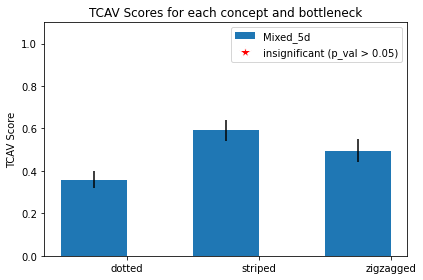

In [25]:
utils_plot.plot_results(
    results, 
    num_random_exp=num_random_exp, 
    random_counterpart='random500_0',)